Цель данного проекта - создание модели для определения рыночной стоимости автомобиля. Нас будет интересовать качество предсказания и время предсказания.

**Описание данных**

Признаки

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя


Целевой признак

- `Price` — цена (евро)


# 1. Подготовка данных

Импортируем необходимые библиотеки:

In [ ]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy import stats as st

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

from tqdm import tqdm
from joblib import dump, load
from IPython.display import display
import time
import warnings

warnings.simplefilter("ignore") #будем игнорировать предупреждения
SEED = 42 #определяем константу, которая будет инициировать случайные числа

Загрузим данные:

In [ ]:
data = pd.read_csv('/datasets/autos.csv')
print(display(data.head()))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


None


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Поскольку данных у нас достаточно много, избавимся от пропущенных данных путем удаления соответствующих строк:

In [ ]:
data.dropna(inplace = True)
data = data.reset_index()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245814 entries, 0 to 245813
Data columns (total 17 columns):
index                245814 non-null int64
DateCrawled          245814 non-null object
Price                245814 non-null int64
VehicleType          245814 non-null object
RegistrationYear     245814 non-null int64
Gearbox              245814 non-null object
Power                245814 non-null int64
Model                245814 non-null object
Kilometer            245814 non-null int64
RegistrationMonth    245814 non-null int64
FuelType             245814 non-null object
Brand                245814 non-null object
NotRepaired          245814 non-null object
DateCreated          245814 non-null object
NumberOfPictures     245814 non-null int64
PostalCode           245814 non-null int64
LastSeen             245814 non-null object
dtypes: int64(8), object(9)
memory usage: 31.9+ MB


Переведем почтовый код в объект типа `object`:

In [ ]:
data['PostalCode'] = data['PostalCode'].astype(object)

Изучим наши признаки подробнее:

In [ ]:
print(display(data.describe()))

,index,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures
count,245814.000000,245814.000000,245814.000000,245814.000000,245814.000000,245814.000000,245814.0
mean,177144.669531,5125.346717,2002.918699,119.970884,127296.716216,6.179701,0.0
std,102310.564337,4717.948673,6.163765,139.387116,37078.820368,3.479519,0.0
min,3.000000,0.000000,1910.000000,0.000000,5000.000000,0.000000,0.0
25%,88476.250000,1499.000000,1999.000000,75.000000,125000.000000,3.000000,0.0
50%,177093.500000,3500.000000,2003.000000,110.000000,150000.000000,6.000000,0.0
75%,265748.500000,7500.000000,2007.000000,150.000000,150000.000000,9.000000,0.0
max,354367.000000,20000.000000,2018.000000,20000.000000,150000.000000,12.000000,0.0


None


In [ ]:
for column in data:
        if data[column].dtype == 'object':
            print('Признак:', column)
            print('Уникальные:', data[column].value_counts().count())
            print()

Признак: DateCrawled
Уникальные: 203782

Признак: VehicleType
Уникальные: 8

Признак: Gearbox
Уникальные: 2

Признак: Model
Уникальные: 249

Признак: FuelType
Уникальные: 7

Признак: Brand
Уникальные: 39

Признак: NotRepaired
Уникальные: 2

Признак: DateCreated
Уникальные: 103

Признак: PostalCode
Уникальные: 8073

Признак: LastSeen
Уникальные: 132195



Видно,что у нас имеются ошибочные значения месяца регистации 0. Удалим эти данные.

In [ ]:
i=0
indexes = []
for row in tqdm(data.values):
    if data.loc[i,'RegistrationMonth'] == 0:
        indexes.append(i)
    i+=1
data = data.drop(indexes, axis = 0)
data = data.reset_index()
print(display(data['RegistrationMonth'].describe()))

100%|██████████| 245814/245814 [00:03<00:00, 77948.99it/s]


count    238283.000000
mean          6.375012
std           3.353295
min           1.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: RegistrationMonth, dtype: float64

None


In [ ]:
data = data.drop (['level_0', 'index'], axis = 1)
data = data.reset_index()

Видно,что у нас имеются ошибочные значения года регистации. Удалим строки с этими значениями.

In [ ]:
i=0
indexes = []
for row in tqdm(data.values):
    if data.loc[i,'RegistrationYear'] < data['RegistrationYear'].quantile(0.0001) or data.loc[i,'RegistrationYear'] > 2016:
        indexes.append(i)
    i+=1
data = data.drop(indexes, axis = 0)
data = data.reset_index()
print(display(data['RegistrationYear'].describe()))

100%|██████████| 238283/238283 [13:40<00:00, 290.58it/s]


count    238254.000000
mean       2003.049023
std           6.092928
min        1950.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

None


Оставим только 2 цифры почтового кода:

In [ ]:
i = 0
for code in tqdm(data['PostalCode']):
    data.loc[i, 'PostalCode'] = str(code)[:1]
    i+=1
data['PostalCode'].head()  

100%|██████████| 238254/238254 [39:48<00:00, 99.74it/s] 


0    9
1    6
2    3
3    6
4    1
Name: PostalCode, dtype: object

Из признаков `RegistrationYear` и `RegistrationMonth` сделаем один в формате `datetime`:

In [ ]:
DateCreated = pd.to_datetime(data['DateCreated'], yearfirst=True)
YearCreated = DateCreated.dt.year.astype(int)
MonthCreated = DateCreated.dt.month.astype(int)
YearRegistration = pd.to_datetime(data['RegistrationYear'], yearfirst=True).astype(int)
MonthRegistration = pd.to_datetime(data['RegistrationMonth'], yearfirst=True).astype(int)

data['RegistrationTime'] = (YearCreated- YearRegistration)*12 + (MonthCreated - MonthRegistration)

Удалим не несущие информации столбцы:

In [ ]:
data = data.drop(['RegistrationYear', 'RegistrationMonth', 'NumberOfPictures', 'DateCrawled', 'DateCreated', 'LastSeen', 'level_0', 'index'], axis = 1)


In [ ]:
print(display(data.head()))

,Price,VehicleType,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,PostalCode,RegistrationTime
0,1500,small,manual,75,golf,150000,petrol,volkswagen,no,9,177
1,3600,small,manual,69,fabia,90000,gasoline,skoda,no,6,92
2,650,sedan,manual,102,3er,150000,petrol,bmw,yes,3,246
3,2200,convertible,manual,109,2_reihe,150000,petrol,peugeot,no,6,140
4,0,sedan,manual,50,other,40000,petrol,volkswagen,no,1,428


None


In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238254 entries, 0 to 238253
Data columns (total 11 columns):
Price               238254 non-null int64
VehicleType         238254 non-null object
Gearbox             238254 non-null object
Power               238254 non-null int64
Model               238254 non-null object
Kilometer           238254 non-null int64
FuelType            238254 non-null object
Brand               238254 non-null object
NotRepaired         238254 non-null object
PostalCode          238254 non-null object
RegistrationTime    238254 non-null int64
dtypes: int64(4), object(7)
memory usage: 20.0+ MB
None


Посмотрим на уникальные значения признаков типа `object`:

In [ ]:
for column in data:
        if data[column].dtype == 'object':
            print('Признак:', column)
            print('Уникальные:', data[column].value_counts())
            print()

Признак: VehicleType
Уникальные: sedan          70193
small          56646
wagon          49647
bus            23142
convertible    15822
coupe          11770
suv             9446
other           1588
Name: VehicleType, dtype: int64

Признак: Gearbox
Уникальные: manual    188340
auto       49914
Name: Gearbox, dtype: int64

Признак: Model
Уникальные: golf                  19473
other                 17865
3er                   14370
polo                   8434
corsa                  7902
                      ...  
i3                        4
samara                    3
serie_3                   3
range_rover_evoque        2
rangerover                1
Name: Model, Length: 249, dtype: int64

Признак: FuelType
Уникальные: petrol      156644
gasoline     77096
lpg           3771
cng            448
hybrid         178
other           67
electric        50
Name: FuelType, dtype: int64

Признак: Brand
Уникальные: volkswagen       50027
bmw              26487
opel             25131
mercedes_b

Построим диаграмму отношений между всеми парами признаков:

In [ ]:
def pairplot(data):
    plt.figure(figsize = (20,20))
    sns.pairplot(data=data)
    plt.show()

In [ ]:
#pairplot(data.sample(frac = 0.1, random_state=SEED))

Четких линейных зависимостей не наблюдается.

Посмотрим на корреляции между признаками и целевым признаком:

In [ ]:
def ranking(y, title='', xlabel='', ylabel=''):
    y_pos = np.arange(len(y),0,-1)
    plt.figure(figsize=(5,5))
    cmap = ListedColormap(sns.color_palette("GnBu_d"))
    bar_colors = cmap(y.values)
    plt.barh(y_pos, width=y, height=0.6, left=None, align='center', color=bar_colors, alpha = 0.8)
    plt.yticks(y_pos, y.index)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for p, c, ch in zip(y_pos, y.index, round(y,4)):
        plt.annotate(str(ch), xy=(ch if ch>0 else 0, p), va='center')

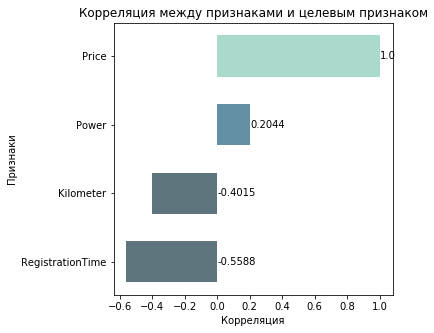

In [ ]:
ranking(data.corr()['Price'], 'Корреляция между признаками и целевым признаком','Корреляция', 'Признаки')

Мы видим сильную отрицательную корреляцию между ценой и временем регистрации автомобиля. Чем старее машина, тем меньше ее стоимость. Зависимость между данными признаками, как показывает диаграмма `pairplot`, нелинейная.

### Вывод

- Мы загрузили данные.

- Поскольку данных у нас достаточно много, избавимся от пропущенных данных путем удаления соответствующих строк.

- Перевели почтовый код в объект типа object и оставили только первые 2 цифры кода, обозначающие регион.

- Удалили строки с ошибочными значениями месяца регистрации.

- Удалили строки с ошибочными значениями года регистрации.

- Удалили неинформативные столбцы.

- Построили диаграмму отношений между всеми парами признаков `pairplot`. Убедились, что четких линейных зависимостей между парами признаков не наблюдается.

- Посмотрели на корреляции между признаками и целевым признаком. Мы видим сильную отрицательную корреляцию между ценой и временем регистрации автомобиля. Чем старее машина, тем меньше ее стоимость. Зависимость между данными признаками, как показывает диаграмма `pairplot`, нелинейная.

# 2. Обучение моделей

Разделим наши данные на признаки `features` и целевой признак `target`.

In [ ]:
features = data.drop("Price", axis = 1)
target = data['Price']

Применим технику `One-Hot-Encoding`:

In [ ]:
collist = []
for column in features:
        if features[column].dtype == 'object':
            collist.append(column)
features = pd.get_dummies(features, drop_first = True, columns = collist)
print(display(features.head()))
collist = features.columns

,Power,Kilometer,RegistrationTime,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_volvo,NotRepaired_yes,PostalCode_2,PostalCode_3,PostalCode_4,PostalCode_5,PostalCode_6,PostalCode_7,PostalCode_8,PostalCode_9
0,75,150000,177,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,69,90000,92,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,102,150000,246,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,109,150000,140,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,50,40000,428,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


None


Применим масштабирование признаком:

In [ ]:
scaler = StandardScaler(with_mean=False)
features = scaler.fit_transform(features)

Разделим выборку на обучающую, валидационную и тестовую:

In [ ]:
features_train_val, features_test, target_train_val, target_test = train_test_split(features, target, test_size=0.25, random_state=SEED)
print(features_train_val.shape, features_test.shape, target_train_val.shape, target_test.shape)

features_train, features_val, target_train, target_val = train_test_split(features_train_val, target_train_val, test_size=0.25, random_state=SEED)
print(features_train.shape, features_val.shape, target_train.shape, target_val.shape)

(178690, 312) (59564, 312) (178690,) (59564,)
(134017, 312) (44673, 312) (134017,) (44673,)


Напишем функцию, которая будет считать метрику `rmse`: 

In [ ]:
def rsme(target_val, target_predicted):
    return np.sqrt(mean_squared_error(target_val, target_predicted))


Напишем функцию, которая будет обучать модель и делать предсказания, выводя на экран время обучения, время предсказания и метрику `rmse`:

In [ ]:
def fit_predict(model, features_train, features_val, target_train, target_val):
    
    start_time = time.time()
    model.fit(features_train, target_train)
    print("Время обучения: %s секунд" % (time.time() - start_time))
    
    start_time = time.time()
    target_predicted = model.predict(features_val)
    prediction_time = (time.time() - start_time)
    print("Время предсказания: %s секунд" % prediction_time)
    
    rmse = rsme(target_val, target_predicted)
    print('RSME=', rmse)
    print()
    return rmse, prediction_time

Напишем функцию, которая будет определять важность признаков для модели и строить график:

In [ ]:
def feature_importance(feature_importance):
       
    importances = pd.DataFrame(feature_importance, columns = ['feature_importances'], index = collist)
    importances = importances.sort_values(by = 'feature_importances', ascending = False).head(10)
    ranking(importances['feature_importances'], title='Feature importance', xlabel='importance', ylabel='feature')

Создадим таблицу, в которую будем запоминать значения метрики и время предсказания разных моделей на валидации:

In [ ]:
score_table = pd.DataFrame('0', columns = ['rmse', 'prediction_time'], index = ['LinearRegression1', 'LinearRegression2',
                                                                                'RandomForest1', 'RandomForest2',
                                                                                'KNeighbors1', 'KNeighbors2',
                                                                                'LGBM1', 'LGBM2',
                                                                                'CatBoost1', 'CatBoost2'])

Исследуем модель линейной регрессии:

In [ ]:
%%time
model = LinearRegression()
score_table.loc['LinearRegression1', 'rmse'], score_table.loc['LinearRegression1', 'prediction_time'] = fit_predict(model, features_train, features_val, target_train, target_val)   

Время обучения: 14.76563310623169 секунд
Время предсказания: 0.1003727912902832 секунд
RSME= 1.0614909768283638e+16

CPU times: user 11.9 s, sys: 3.03 s, total: 14.9 s
Wall time: 14.9 s


Исследуем модель линейной регрессии с другими параметрами:

In [ ]:
params= {'fit_intercept': True,
          'normalize': True
         }

model_linear = LinearRegression(**params)
score_table.loc['LinearRegression2', 'rmse'], score_table.loc['LinearRegression2', 'prediction_time'] = fit_predict(model, features_train, features_val, target_train, target_val)

Время обучения: 14.296679735183716 секунд
Время предсказания: 0.10270261764526367 секунд
RSME= 1.0614909768283638e+16



Исследуем модель случайного леса:

Время обучения: 53.98470973968506 секунд
Время предсказания: 0.3133978843688965 секунд
RSME= 1692.0088489440461

CPU times: user 53.3 s, sys: 117 ms, total: 53.5 s
Wall time: 54.4 s


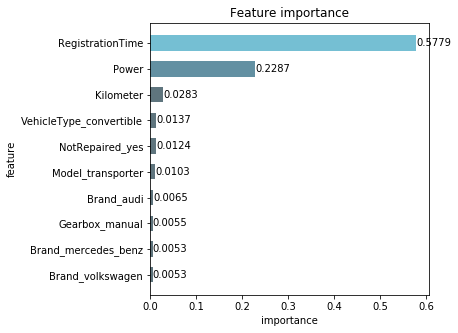

In [ ]:
%%time
model = RandomForestRegressor(random_state =SEED)
score_table.loc['RandomForest1', 'rmse'], score_table.loc['RandomForest1', 'prediction_time'] = fit_predict(model, features_train, features_val, target_train, target_val)

feature_importance(model.feature_importances_)

Исследуем модель случайного леса с другими параметрами:

Время обучения: 1002.5146887302399 секунд
Время предсказания: 4.505340337753296 секунд
RSME= 1629.9646647867075



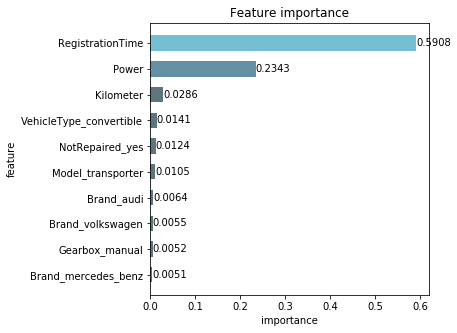

In [ ]:
params= ({'n_estimators': (200),
         'min_samples_leaf': (2),
          'random_state': SEED
         })

model = RandomForestRegressor(**params)
score_table.loc['RandomForest2', 'rmse'], score_table.loc['RandomForest2', 'prediction_time']= fit_predict(model, features_train, features_val, target_train, target_val)

feature_importance(model.feature_importances_)

Исследуем модель ближайших соседей:

In [ ]:
%%time
model =  KNeighborsRegressor()
score_table.loc['KNeighbors1', 'rmse'], score_table.loc['KNeighbors1', 'prediction_time'] = fit_predict(model, features_train, features_val, target_train, target_val)

Время обучения: 91.65709209442139 секунд
Время предсказания: 2118.0174689292908 секунд
RSME= 2340.7137145889133

CPU times: user 36min 34s, sys: 1.1 s, total: 36min 35s
Wall time: 36min 49s


Исследуем модель ближайших соседей с другими параметрами:

In [ ]:
params= ({'weights': ("uniform"),
          'leaf_size': (50)
         })
model = KNeighborsRegressor(**params)
score_table.loc['KNeighbors2', 'rmse'], score_table.loc['KNeighbors2', 'prediction_time'] = fit_predict(model, features_train, features_val, target_train, target_val)

Время обучения: 94.23793888092041 секунд
Время предсказания: 2112.040126800537 секунд
RSME= 2340.5717542379966



Исследуем модель градиентного бустинга `LGBMRegressor`:

Время обучения: 10.961158752441406 секунд
Время предсказания: 0.6039564609527588 секунд
RSME= 1728.200422463066

CPU times: user 11.4 s, sys: 34.1 ms, total: 11.4 s
Wall time: 11.7 s


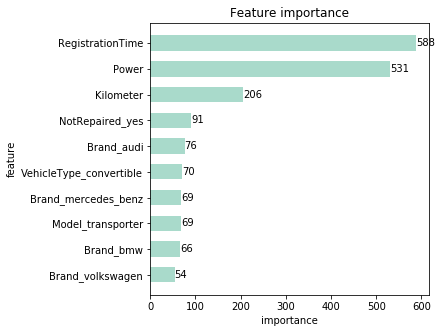

In [ ]:
%%time
model = LGBMRegressor(random_state =SEED)
score_table.loc['LGBM1', 'rmse'], score_table.loc['LGBM1', 'prediction_time'] = fit_predict(model, features_train, features_val, target_train, target_val)

feature_importance(model.feature_importances_)

Исследуем модель градиентного бустинга `LGBMRegressor`с другими параметрами, попробуем подобрать наилучшие из списка параметров:

{'learning_rate': 0.5, 'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 3, 'random_state': 42}
Время обучения: 22.303576231002808 секунд
Время предсказания: 2.008018970489502 секунд
RSME= 1692.5761276944093



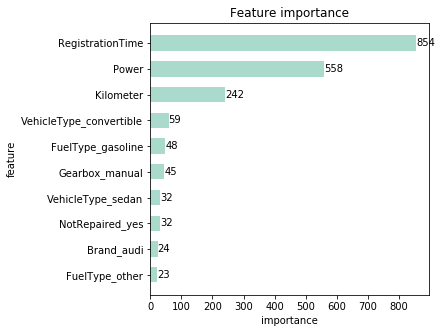

In [ ]:
params = ({'learning_rate': (0.01, 0.1, 0.5),
                  'n_estimators': (50, 100, 500),
                  'min_samples_split': (2, 3),
                  'max_depth': (2,3),
                  'random_state': SEED
          })

best= {'random_state': SEED}
model = LGBMRegressor(**best)
model.fit(features_train, target_train)
dump(model, 'best_model.joblib')
best_score=0
for p1 in params.get('learning_rate'):
    for p2 in params.get('n_estimators'):
        for p3 in params.get('min_samples_split'):
            for p4 in params.get('max_depth'):
                
                best_model = load('best_model.joblib')
                best_preds = best_model.predict(features_val)
                best_score = rsme(target_val, best_preds)
                
                model = LGBMRegressor(random_state = SEED, learning_rate=p1, n_estimators= p2, min_samples_split= p3, max_depth=p4)
                model.fit(features_train, target_train)
                preds = model.predict(features_val)
            
                if rsme(target_val, preds)< best_score:
                    dump(model, 'best_model.joblib')
                    best= {'learning_rate':p1, 'n_estimators':p2, 'min_samples_split':p3, 'max_depth':p4, 'random_state': SEED}
                    
print(best)
model = LGBMRegressor(**best)
score_table.loc['LGBM2', 'rmse'], score_table.loc['LGBM2', 'prediction_time'] = fit_predict(model, features_train, features_val, target_train, target_val)

feature_importance(model.feature_importances_)

Исследуем модель градиентого бустинга `CatBoostRegressor`:

0:	learn: 4638.3049454	total: 155ms	remaining: 2m 34s
500:	learn: 1782.4523558	total: 55.2s	remaining: 54.9s
999:	learn: 1691.0272383	total: 1m 49s	remaining: 0us
Время обучения: 125.328120470047 секунд
Время предсказания: 3.8118293285369873 секунд
RSME= 1733.3863119255666

CPU times: user 1min 55s, sys: 11.4 s, total: 2min 7s
Wall time: 2min 9s


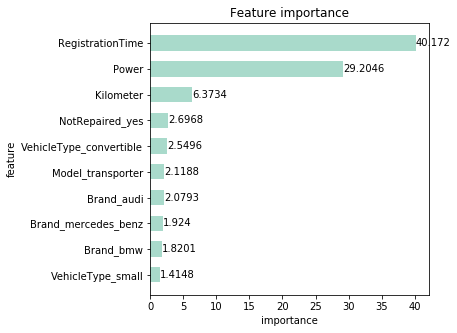

In [ ]:
%%time
model = CatBoostRegressor(random_state =SEED, verbose=500)
score_table.loc['CatBoost1', 'rmse'], score_table.loc['CatBoost1', 'prediction_time'] = fit_predict(model, features_train, features_val, target_train, target_val)
feature_importance(model.get_feature_importance())

Исследуем модель градиентого бустинга `CatBoostRegressor` с другими параметрами:

0:	learn: 4395.2341835	total: 199ms	remaining: 3m 18s
500:	learn: 1498.6092966	total: 1m 41s	remaining: 1m 41s
999:	learn: 1385.4623065	total: 3m 25s	remaining: 0us
Время обучения: 221.88207745552063 секунд
Время предсказания: 4.302812576293945 секунд
RSME= 1602.982687967631



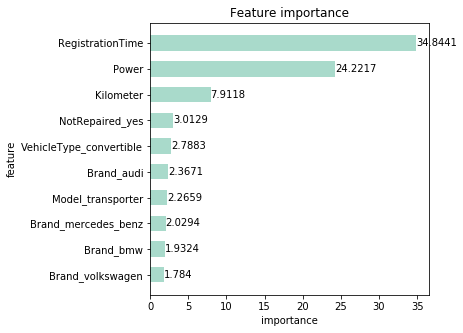

In [ ]:
params = ({'learning_rate': 0.1,
        'depth': 10,
        'l2_leaf_reg': 5,
         'random_state': SEED,
         'verbose': 500})

model = CatBoostRegressor(**params)
score_table.loc['CatBoost2', 'rmse'], score_table.loc['CatBoost2', 'prediction_time'] = fit_predict(model, features_train, features_val, target_train, target_val)

feature_importance(model.get_feature_importance())

### Вывод

- Мы разделили данные на признаки `features` и целевой признак `target`.

- Применили технику `One-Hot-Encoding` и масштабирование признаков.

- Разделили выборку на обучающую, валидационную и тестовую.

- Написали функцию, которая будет считать метрику `rmse` 

- Написали функцию, которая будет обучать модель и делать предсказания, выводя на экран время обучения, время предсказания и метрику `rmse`.

- Написали функцию, которая будет определять важность признаков для модели и строить график.

- Создали таблицу, в которую запоминаются значения метрики и времени предсказания разных моделей на валидации.

- Исследовали модель линейной регрессии с параметрами по умолчанию и измененными параметрами.

- Исследовали модель случайного леса с параметрами по умолчанию и измненными параметрами.

- Исследовали модель ближайших соседей с параметрами по умолчанию и измененными параметрами.

- Исследовали модель градиентного бустинга `LGBMRegressor` с параметрами по умолчанию и параметрами, подобранными из списка.

- Исследовали модель градиентого бустинга `CatBoostRegressor` с параметрами по умолчанию и измененными параметрами.


# 3. Анализ моделей

Посмотрим на получившуюся таблицу результатов:

In [ ]:
print(score_table)

                          rmse prediction_time
LinearRegression1  1.06149e+16        0.100373
LinearRegression2  1.06149e+16        0.102703
RandomForest1          1692.01        0.313398
RandomForest2          1629.96         4.50534
KNeighbors1            2340.71         2118.02
KNeighbors2            2340.57         2112.04
LGBM1                   1728.2        0.603956
LGBM2                  1692.58         2.00802
CatBoost1              1733.39         3.81183
CatBoost2              1602.98         4.30281


По таблице видно , что лучшее значение по метрике `rsme` имеет модель градиентного бустинга `CatBoost` с измененными параметрами. Лучшее значение по времени предсказания имеет модель линейной регрессии, однако она дает плохой результат по метрике. На втором месте по скорости предсказания - модель случайного леса с параметрами по умолчанию.

Протестируем модель градиентного бустинга `CatBoost` с измененными параметрами и модель случайного леса с параметрами по умолчанию на тестовой выборке, а затем сравним результаты с `DummyRegressor` - константной моделью. Создадим новую таблицу для тестовых результатов:

In [ ]:
score_table_test = pd.DataFrame('0', columns = ['rmse', 'prediction_time'], index = ['RandomForest', 
                                                                                'CatBoost', 'Dummy'])

Обучим заново и найдем предсказания на тестовой выборке модели случайного леса:

Время обучения: 76.36243939399719 секунд
Время предсказания: 0.4531524181365967 секунд
RSME= 1690.7183802900006



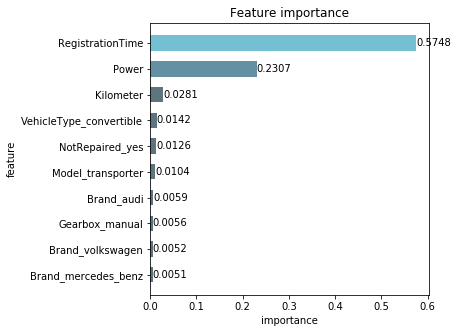

In [ ]:
model = RandomForestRegressor(random_state =SEED)
score_table_test.loc['RandomForest', 'rmse'], score_table_test.loc['RandomForest', 'prediction_time'] = fit_predict(model, features_train_val, features_test, target_train_val, target_test)
feature_importance(model.feature_importances_)

Обучим заново и найдем предсказания на тестовой выборке модели градиентного бустинга `CatBoostRegressor`:

0:	learn: 4393.4764412	total: 150ms	remaining: 2m 29s
500:	learn: 1516.2924333	total: 2m 3s	remaining: 2m 3s
999:	learn: 1412.9590977	total: 4m 7s	remaining: 0us
Время обучения: 268.4696490764618 секунд
Время предсказания: 5.085597276687622 секунд
RSME= 1598.1737198359174



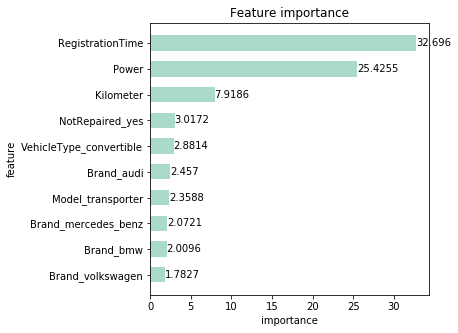

In [ ]:
params = ({'learning_rate': 0.1,
        'depth': 10,
        'l2_leaf_reg': 5,
         'random_state': SEED,
         'verbose': 500})

model = CatBoostRegressor(**params)
score_table_test.loc['CatBoost', 'rmse'], score_table_test.loc['CatBoost', 'prediction_time'] = fit_predict(model, features_train_val, features_test, target_train_val, target_test)
feature_importance(model.get_feature_importance())

Построим, обучим и найдем предсказания на тестовой выборке константной модели:

In [ ]:
model = DummyRegressor(strategy = 'median')
score_table_test.loc['Dummy', 'rmse'], score_table_test.loc['Dummy', 'prediction_time'] = fit_predict(model, features_train_val, features_test, target_train_val, target_test)

Время обучения: 0.0037665367126464844 секунд
Время предсказания: 0.00044655799865722656 секунд
RSME= 5005.46538870644



Посмотрим на таблицу результатов на тесте:

In [ ]:
print(score_table_test)

                 rmse prediction_time
RandomForest  1690.72        0.453152
CatBoost      1598.17          5.0856
Dummy         5005.47     0.000446558


Наилучшее значение метрики `rmse` по-прежнему даает модель градиентного бустинга `CatBoost`. Лучшее время предсказания у случайного леса. Обе эти модели дают существенно лучший результат, чем константная модель.

Важность факторов для всех построенных моделей: первые 3 места занимают время регистрации автомобиля, мощность двигателя и пробег автомобиля. 

### Вывод

- Мы посмотрели на получившуюся таблицу результатов на валидации. По таблице видно, что лучшее значение по метрике `rsme` имеет модель градиентного бустинга `CatBoost` с измененными параметрами `rmse = 1602.98`. Лучшее значение по времени предсказания имеет модель случайного леса с параметрами по умолчанию `t= 0.313398`.

- Обучили заново и нашли предсказания на тестовой выборке модели случайного леса с параметрами по умолчанию.

- Обучили заново и нашли предсказания на тестовой выборке модели градиентного бустинга `CatBoostRegressor`.

- Построили, обучили и нашли предсказания на тестовой выборке константной модели `DummyRegressor`, где константа - медиана обучающей выборки.

- Наилучшее значение метрики `rmse` по-прежнему дает модель градиентного бустинга `CatBoost` `rmse = 1598.17`. Лучшее время предсказания у случайного леса `t= 0.453152`. Обе эти модели дают существенно лучший результат, чем константная модель.

- Важность факторов для всех построенных моделей: первые 3 места занимают время регистрации автомобиля, мощность двигателя и пробег автомобиля. 

## Общий вывод

- Мы загрузили данные.

- Поскольку данных у нас достаточно много, избавимся от пропущенных данных путем удаления соответствующих строк.

- Перевели почтовый код в объект типа object и оставили только первые 2 цифры кода, обозначающие регион.

- Удалили строки с ошибочными значениями месяца регистрации.

- Удалили строки с ошибочными значениями года регистрации.

- Удалили неинформативные столбцы.

- Построили диаграмму отношений между всеми парами признаков `pairplot`. Убедились, что четких линейных зависимостей между парами признаков не наблюдается.

- Посмотрели на корреляции между признаками и целевым признаком. Мы видим сильную отрицательную корреляцию между ценой и временем регистрации автомобиля. Чем старее машина, тем меньше ее стоимость. Зависимость между данными признаками, как показывает диаграмма `pairplot`, нелинейная.

- Мы разделили данные на признаки `features` и целевой признак `target`.

- Применили технику `One-Hot-Encoding` и масштабирование признаков.

- Разделили выборку на обучающую, валидационную и тестовую.

- Написали функцию, которая будет считать метрику `rmse` 

- Написали функцию, которая будет обучать модель и делать предсказания, выводя на экран время обучения, время предсказания и метрику `rmse`.

- Написали функцию, которая будет определять важность признаков для модели и строить график.

- Создали таблицу, в которую запоминаются значения метрики и времени предсказания разных моделей на валидации.

- Исследовали модель линейной регрессии с параметрами по умолчанию и измененными параметрами.

- Исследовали модель случайного леса с параметрами по умолчанию и измненными параметрами.

- Исследовали модель ближайших соседей с параметрами по умолчанию и измененными параметрами.

- Исследовали модель градиентного бустинга `LGBMRegressor` с параметрами по умолчанию и параметрами, подобранными из списка.

- Исследовали модель градиентого бустинга `CatBoostRegressor` с параметрами по умолчанию и измененными параметрами.

- Мы посмотрели на получившуюся таблицу результатов на валидации. По таблице видно, что лучшее значение по метрике `rsme` имеет модель градиентного бустинга `CatBoost` с измененными параметрами `rmse = 1602.98`. Лучшее значение по времени предсказания имеет модель случайного леса с параметрами по умолчанию `t= 0.313398`.

- Обучили заново и нашли предсказания на тестовой выборке модели случайного леса с параметрами по умолчанию.

- Обучили заново и нашли предсказания на тестовой выборке модели градиентного бустинга `CatBoostRegressor`.

- Построили, обучили и нашли предсказания на тестовой выборке константной модели `DummyRegressor`, где константа - медиана обучающей выборки.

- Наилучшее значение метрики `rmse` по-прежнему дает модель градиентного бустинга `CatBoost` `rmse = 1598.17`. Лучшее время предсказания у случайного леса `t= 0.453152`. Обе эти модели дают существенно лучший результат, чем константная модель.

- Важность факторов для всех построенных моделей: первые 3 места занимают время регистрации автомобиля, мощность двигателя и пробег автомобиля. 